# Forecasting Home Prices in the GTA

## Introduction
### Dataset

This is a GTA Housing dataset from TREB (Toronto Real Estate Board). The dataset was aggregated from a script I created and it consists of time series data ranging from 1996 to 2020 for several municipalities/communities and home types.

The different hometypes are: Townhouses, Condo Apartments, Condo Townhouses, Co-Op Apartments, Co-Ownership Apartments, Detached Condos, Detached Houses, Links, and Semi-Detached Homes.

The different cities are Brampton, Caledon, Mississauga, Ajax, Brock,
       Clarington, Oshawa, Pickering, Scugog, Uxbridge,
       Whitby, Aurora, East Gwillimbury, Georgina, King,
       Markham, Newmarket, Richmond Hill, Vaughan,
       Whitchurch-Stouffville, Burlington, Halton Hills, Milton,
       Oakville, Orangeville, Toronto C01, Toronto C02,
       Toronto C03, Toronto C04, Toronto C06, Toronto C07,
       Toronto C08, Toronto C09, Toronto C10, Toronto C11,
       Toronto C12, Toronto C13, Toronto C14, Toronto C15,
       Toronto E01, Toronto E02, Toronto E03, Toronto E04,
       Toronto E05, Toronto E06, Toronto E07, Toronto E08,
       Toronto E09, Toronto E10, Toronto E11, Toronto W01,
       Toronto W02, Toronto W03, Toronto W04, Toronto W05,
       Toronto W06, Toronto W07, Toronto W08, Toronto W09,
       Toronto W10, Adjala-Tosorontio, Bradford West Gwillimbury,
       Essa, Innisfil, New Tecumseth

A thorough Exploratory Data Analysis notebook was done and can be seen [here](https://github.com/michaelarman/GTA_Housing/blob/main/Housing%20exploration.ipynb)

### Objective

The objective of this notebook will be to investigate forecasting of monthly home prices. There are many approaches to time series forecasting and it's a very complex topic. Forecasting monthly prices can be very very beneficial since it can give a person an idea of when the best time to buy or sell is (based on seasonality) and which areas might have the best ROI.

The data obtained has several variables and many group combinations. 
Different approaches may include:
- creating a different model for each group
- creating a univariate model
- creating a model that takes into account covariates
- experimenting with additional features such as time lags, mortgage interest rates, population growth

The library I find the best for forecasting is [pytorch-forecasting](https://pytorch-forecasting.readthedocs.io/en/latest/index.html). They've implemented many of the latest time series models which have the best up to date performance.

The reason why I will go with the deep learning approach for time series forecasting rather than the traditional time series methods is because recently deep learning (neural networks) has outperformed traditional methods in time series forecasting. Moreover the deep learning approach can properly handle covariates,neural network architectures can be designed with an inherent understanding of time, i.e. they automatically make a connection between temporally close data points and thus they can capture complex time dependencies. Neural networks employ continuous activation functions and are particularly good at interpolation in high-dimensional spaces, i.e. they can be used to optimize inputs.

# Imports

In [98]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting import Baseline, NBeats, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import tensorflow as tf 
import tensorboard as tb 
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pickle
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load and Preprocess Data 

In [2]:
housing = pd.read_csv('MLS_Datasets/all_cities.csv')
housing = housing.drop(columns='Unnamed: 0')
month = [x[0] for x in housing['Date'].str.split("'")]
year = [x[1] for x in housing['Date'].str.split("'")]
year = ['19'+x if x[0] == '9' else '20'+x for x in year]
housing['Date'] = pd.to_datetime(pd.Series(month).str.strip() + '/' + pd.Series(year))
housing['Month'] = housing['Date'].dt.month
housing['Year'] = housing['Date'].dt.year
df = housing[housing['HomeType'] != 'All values']

df.loc[df["Average SP/LP"] == 770000, ['Average SP/LP']] = 1 # change apparent outlier

# it's possible that the median would be the more appropriate metric for these features especially if there is skew
# this would highly depend on the city+hometype combination
df_medians = df.groupby(['Geography','HomeType','Year'])[['Sales','Average Price','New Listings','SNLR','Active Listings','MOI','Average DOM','Average SP/LP']].transform('median')
df['Median Sales of Year'] = df_medians['Sales']
df['Sales YoY'] = df['Median Sales of Year'].pct_change(12)
df['Median Price of Year'] = df_medians['Average Price']
df['Price YoY'] = df['Median Price of Year'].pct_change(12)
df['Median New Listings of Year'] =  df_medians['New Listings']
df['New Listings YoY'] = df['Median New Listings of Year'].pct_change(12)
df['Median SNLR of Year'] = df_medians['SNLR']
df['SNLR YoY'] = df['Median SNLR of Year'].pct_change(12)
df['Median Active Listings of Year'] =  df_medians['Active Listings']
df['Active Listings YoY'] = df['Median Active Listings of Year'].pct_change(12)
df['Median MOI of Year'] =  df_medians['MOI']
df['MOI YoY'] = df['Median MOI of Year'].pct_change(12)
df['Median DOM of Year'] =  df_medians['Average DOM']
df['DOM YoY'] = df['Median DOM of Year'].pct_change(12)
df['Median SP/LP of Year'] =  df_medians['Average SP/LP']
df['SP/LP YoY'] = df['Median SP/LP of Year'].pct_change(12)
# need to impute 0's for beginning year 1996
df.loc[df['Year'] == 1996, ['Sales YoY', 'Price YoY', 'New Listings YoY', 'SNLR YoY', 'Active Listings YoY', 'MOI YoY', 'DOM YoY', 'SP/LP YoY']] = 0

df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

C:\Users\Michael\.conda\envs\mls\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-2-9e32ebe6ebf1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Median Sales of Year'] = df_medians['Sales']
<ipython-input-2-9e32ebe6ebf1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [3]:
df.head()

,Date,Sales,Dollar Volume,Average Price,New Listings,SNLR,Active Listings,MOI,Average DOM,Average SP/LP,...,Median SNLR of Year,SNLR YoY,Median Active Listings of Year,Active Listings YoY,Median MOI of Year,MOI YoY,Median DOM of Year,DOM YoY,Median SP/LP of Year,SP/LP YoY
0,1996-01-01,24.0,3418500.0,142437.50000,44.0,0.545455,53.0,2.208333,44.875000,0.970433,...,0.775847,0.0,48.5,0.0,1.748889,0.0,44.520834,0.0,0.96798,0.0
1,1996-02-01,21.0,2871200.0,136723.81250,32.0,0.656250,57.0,2.714286,56.142857,0.963460,...,0.775847,0.0,48.5,0.0,1.748889,0.0,44.520834,0.0,0.96798,0.0
2,1996-03-01,42.0,6031600.0,143609.53125,33.0,1.272727,41.0,0.976190,44.166668,0.964520,...,0.775847,0.0,48.5,0.0,1.748889,0.0,44.520834,0.0,0.96798,0.0
3,1996-04-01,25.0,3502250.0,140090.00000,33.0,0.757576,43.0,1.720000,33.680000,0.965325,...,0.775847,0.0,48.5,0.0,1.748889,0.0,44.520834,0.0,0.96798,0.0
4,1996-05-01,22.0,3137600.0,142618.18750,44.0,0.500000,53.0,2.409091,32.727272,0.967883,...,0.775847,0.0,48.5,0.0,1.748889,0.0,44.520834,0.0,0.96798,0.0


## Base Model for One City+Home Type Combination

Let's start with a base model for Brampton Detached homes and see how well that performs.

In [119]:
brampton_detached[brampton_detached['Date'].dt.year.isin(list(range(2010,2021)))]

,Date,Sales,Dollar Volume,Average Price,New Listings,SNLR,Active Listings,MOI,Average DOM,Average SP/LP,...,Median Active Listings of Year,Active Listings YoY,Median MOI of Year,MOI YoY,Median DOM of Year,DOM YoY,Median SP/LP of Year,SP/LP YoY,time_idx,count_idx
1427,2010-01-01,272.0,110827875.0,407455.43750,539.0,0.504638,590.0,2.169118,27.404411,0.982964,...,959.5,-0.051409,2.600528,0.259799,27.676983,-0.160032,0.973484,0.000069,168,299
1428,2010-02-01,374.0,152171441.0,406875.50000,721.0,0.518724,746.0,1.994652,18.652407,0.985460,...,959.5,-0.051409,2.600528,0.259799,27.676983,-0.160032,0.973484,0.000069,169,299
1429,2010-03-01,562.0,225965553.0,402073.93750,1048.0,0.536260,971.0,1.727758,16.106762,0.983516,...,959.5,-0.051409,2.600528,0.259799,27.676983,-0.160032,0.973484,0.000069,170,299
1430,2010-04-01,539.0,222637161.0,413055.96875,1076.0,0.500929,1144.0,2.122449,20.699444,0.980889,...,959.5,-0.051409,2.600528,0.259799,27.676983,-0.160032,0.973484,0.000069,171,299
1431,2010-05-01,470.0,198222290.0,421749.56250,985.0,0.477157,1239.0,2.636170,21.470213,0.979457,...,959.5,-0.051409,2.600528,0.259799,27.676983,-0.160032,0.973484,0.000069,172,299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,2020-07-01,666.0,657997085.0,987983.62500,908.0,0.733480,520.0,0.780781,14.819819,0.997894,...,482.0,-0.290133,0.954545,-0.442654,13.870021,-0.291654,1.006321,0.021631,294,299
1554,2020-08-01,638.0,630915321.0,988895.50000,1009.0,0.632309,609.0,0.954545,11.957681,1.006321,...,482.0,-0.290133,0.954545,-0.442654,13.870021,-0.291654,1.006321,0.021631,295,299
1555,2020-09-01,632.0,629634366.0,996256.93750,926.0,0.682505,582.0,0.920886,13.243671,1.006681,...,482.0,-0.290133,0.954545,-0.442654,13.870021,-0.291654,1.006321,0.021631,296,299
1556,2020-10-01,615.0,613066369.0,996855.87500,800.0,0.768750,475.0,0.772358,13.393496,1.009106,...,482.0,-0.290133,0.954545,-0.442654,13.870021,-0.291654,1.006321,0.021631,297,299


In [182]:
brampton_detached = df[(df['Geography'] == 'Brampton') & (df['HomeType'] == 'Detached')]
# add time index
brampton_detached['time_idx'] = brampton_detached['Date'].dt.year *12 + brampton_detached['Date'].dt.month
brampton_detached['time_idx'] -= brampton_detached['time_idx'].min()
# create feature to get count of time_idx in case of missing time sequences
brampton_detached['count_idx'] = brampton_detached.groupby(['Geography','HomeType'])['time_idx'].transform('count')
# filter out time series with missing sequences
brampton_detached = brampton_detached[brampton_detached['count_idx'] >= 200] # set a threshold of missing sequences

# try using the last 10-11 years
# brampton_detached = brampton_detached[brampton_detached['Date'].dt.year.isin(list(range(2010,2021)))]

brampton_detached['Month'] = brampton_detached['Month'].astype(str).astype('category')
brampton_detached['Year'] = brampton_detached['Year'].astype(str).astype('category')


<ipython-input-182-1fa1998fb7a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brampton_detached['time_idx'] = brampton_detached['Date'].dt.year *12 + brampton_detached['Date'].dt.month
<ipython-input-182-1fa1998fb7a0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brampton_detached['time_idx'] -= brampton_detached['time_idx'].min()
<ipython-input-182-1fa1998fb7a0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [174]:
brampton_detached.describe()

,Sales,Dollar Volume,Average Price,New Listings,SNLR,Active Listings,MOI,Average DOM,Average SP/LP,Median Sales of Year,...,Median Active Listings of Year,Active Listings YoY,Median MOI of Year,MOI YoY,Median DOM of Year,DOM YoY,Median SP/LP of Year,SP/LP YoY,time_idx,count_idx
count,131.000000,1.310000e+02,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,...,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0
mean,388.183206,2.507248e+08,634719.580391,710.206107,0.573652,755.152672,2.118469,21.668404,0.985846,389.885496,...,810.763359,0.004196,2.062476,0.077516,21.277896,-0.043988,0.984784,0.002962,233.000000,299.0
std,123.558943,1.228293e+08,181760.234056,234.425311,0.159939,265.386843,0.894794,6.393949,0.018220,52.004459,...,206.344068,0.453195,0.686888,0.732118,4.782138,0.257821,0.011544,0.012358,37.960506,0.0
min,125.000000,8.135314e+07,402073.937500,187.000000,0.293274,186.000000,0.428571,6.639344,0.962769,322.000000,...,430.500000,-0.375181,0.879789,-0.442654,12.480147,-0.304535,0.973484,-0.023233,168.000000,299.0
25%,282.500000,1.602964e+08,477799.296875,540.500000,0.475902,535.500000,1.470000,17.897543,0.975938,346.000000,...,679.000000,-0.220436,1.431231,-0.339083,17.945037,-0.261350,0.976985,-0.002837,200.500000,299.0
50%,378.000000,2.235602e+08,571538.125000,768.000000,0.536260,767.000000,2.077640,22.484375,0.980448,382.000000,...,871.000000,-0.152163,2.144320,-0.175429,22.974915,-0.160032,0.979072,0.003864,233.000000,299.0
75%,475.500000,3.235404e+08,808141.593750,859.000000,0.634739,968.500000,2.743119,25.555063,0.987320,418.000000,...,981.000000,0.132518,2.600528,0.183724,24.294376,0.162725,0.987320,0.008904,265.500000,299.0
max,679.000000,6.579971e+08,996855.875000,1444.000000,1.183246,1308.000000,4.583012,38.081341,1.081678,502.000000,...,1111.000000,1.328688,2.897916,2.256352,27.676983,0.582853,1.009303,0.022265,298.000000,299.0


Note: The standard deviation of the average price of detached homes in Brampton is \\$219,299.27 for the entire dataset. Below we can see the standard deviation of the last 3 years is \\$66,937.75

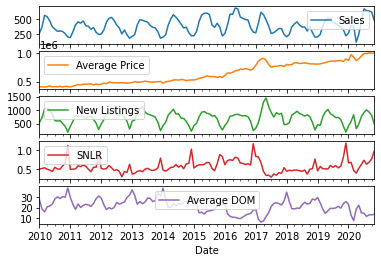

In [125]:
plot_cols = ['Sales', 'Average Price', 'New Listings', 'SNLR', 'Average DOM']
plot_features = brampton_detached[plot_cols]
plot_features.index = brampton_detached['Date']
_ = plot_features.plot(subplots=True)

To use the Pytorch Forecasting Models we will need to convert the dataset into Pytorch's TimeSeries Dataset.
This dataset has many arguments and it's really neat because it organizes our dataset into static, dynamic, known, unknown, categorical, continuous variables. We can also tell it to create lags, how to normalize the data, how to encode the categorical variables, etc.. In the data below, the validation dataset will contain the last six months, and the maximum prediction length will also be 6 months.

In [183]:
max_prediction_length = 10
max_encoder_length = 24
training_cutoff = brampton_detached["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    brampton_detached[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Average Price",
    group_ids=["Geography", "HomeType"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Geography", "HomeType"],
    static_reals=[],
    time_varying_known_categoricals=["Year", "Month"],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Sales",
        "Average Price",
        "Dollar Volume",
        "New Listings",
        "SNLR",
        "Active Listings",
        "MOI",
        "Average DOM",
        "Average SP/LP",
        "Median Price of Year"
    ],
    target_normalizer=GroupNormalizer(
        groups=["Geography", "HomeType"]
    ),  # use softplus and normalize by group
    allow_missings = True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(dataset=training, data=brampton_detached, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Now we will calculate the MAE of the Baseline model. This baseline model uses last known target value to make prediction.

In [184]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

88318.515625

Using the Baseline Model we obtain a mean absolute error of \\$88,116.72 meaning that on average, the model is off from the actual price of the month by \\$88,116.72. Now let's see if we can obtain better results with a time series model from pytorch forecasting. First we will try the Temporal Fusion Transformer model which is an attention based neural network which combines high performance multi-horizon forecasting with interpretable insights into temporal dynamics.

In [168]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Number of parameters in network: 26.6k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 140   
3  | prescalers                         | ModuleDict                      | 240   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\Michael\MLS\lr_find_temp_model.ckpt


suggested learning rate: 0.09332543007969905


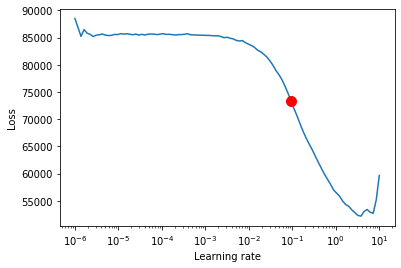

<ipython-input-169-a92b5627800b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [169]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [170]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Number of parameters in network: 26.6k


In [171]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 140   
3  | prescalers                         | ModuleDict                      | 240   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [175]:

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=20,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study_brampton_detached.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-02-13 22:53:58,063] A new study created in memory with name: no-name-d2a5ac8c-955e-44f6-9d07-c2c92d8c5c6a
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-13 22:55:09,479] Trial 0 finished with value: 179694.53125 and parameters: {'gradient_clip_val': 0.026761277096084984, 'hidden_size': 11, 'dropout': 0.2601456364118664, 'hidden_continuous_size': 11, 'attention_head_size': 4, 'learning_rate': 0.008932574446442989}. Best is trial 0 with value: 179694.53125.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-13 22:56:30,855] Trial 1 finished with value: 176898.671875 and parameters: {'gradient_clip_val': 0.283544139522678, 'hidden_size': 13, 'dropout': 0.23662003243346075, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.00229442794056075}. Best is trial 1 with value: 176898.671875.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-13 22:58:36,326] T

{'gradient_clip_val': 0.07887309766727026, 'hidden_size': 127, 'dropout': 0.1036836266848944, 'hidden_continuous_size': 51, 'attention_head_size': 3, 'learning_rate': 0.025095673643181795}


In [176]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [185]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

IndexError: index out of range in self

In [145]:
88116.71875 - 78741.2266 # baseline mae - tft mae

9375.492150000005

The TFT model was more accurate by an average of ~\\$10,000. Not super significant improvements but still good. We can try a few things:
- use a different model completely
- add features such as lags or from external data sources
- run for more epochs
- decrease the training period

## Creating a Model for a Home Type
It makes more sense to make separate models for different home types as opposed to different cities since there is less intra variance within home types than cities

In [146]:
detached = df[(df['HomeType'] == 'Detached')]
# add time index
detached['time_idx'] = detached['Date'].dt.year *12 + detached['Date'].dt.month
detached['time_idx'] -= detached['time_idx'].min()
# create feature to get count of time_idx in case of missing time sequences
detached['count_idx'] = detached.groupby(['Geography'])['time_idx'].transform('count')
# filter out time series with missing sequences
detached = detached[detached['count_idx'] >= 200] # set a threshold of missing sequences

# try using the last 10-11 years
detached = detached[detached['Date'].dt.year.isin(list(range(2010,2021)))]

detached['Month'] = detached['Month'].astype(str).astype('category')
detached['Year'] = detached['Year'].astype(str).astype('category')

<ipython-input-146-bfe9f4fd26f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detached['time_idx'] = detached['Date'].dt.year *12 + detached['Date'].dt.month
<ipython-input-146-bfe9f4fd26f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detached['time_idx'] -= detached['time_idx'].min()
<ipython-input-146-bfe9f4fd26f0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [75]:
# experiment with lags and timeseries dataset

,Municipality,Geography,HomeType
count,19136,19136,19136
unique,7,64,1
top,Toronto,Halton Hills,Detached
freq,10166,299,19136


In [147]:
max_prediction_length = 10
max_encoder_length = 24
training_cutoff = detached["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    detached[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Average Price",
    group_ids=["Geography", "HomeType"],
    min_encoder_length=max_encoder_length // 4,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Geography", "HomeType"],
    static_reals=[],
    time_varying_known_categoricals=["Year", "Month"],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Sales",
        "Average Price",
        "Dollar Volume",
        "New Listings",
        "SNLR",
        "Active Listings",
        "MOI",
        "Average DOM",
        "Average SP/LP",
        "Median Price of Year"
    ],
    target_normalizer=GroupNormalizer(
        groups=["Geography", "HomeType"]
    ),  # use softplus and normalize by group
    allow_missings = True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(dataset=training, data=detached, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)



In [148]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

199263.453125

## N-Beats Univariate Prediction

In [149]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 12

training_cutoff = detached["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    detached[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Average Price",
#     categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["Geography", "HomeType"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["Average Price"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missings=True
)

validation = TimeSeriesDataSet.from_dataset(training, detached, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [150]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

183675.78125

In [95]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.1375)

In [99]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\Michael\MLS\lr_find_temp_model.ckpt


suggested learning rate: 0.001122018454301963


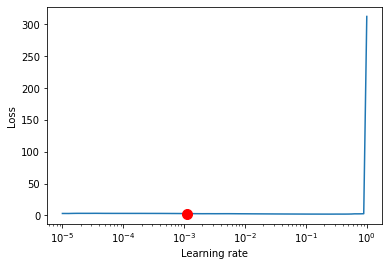

<ipython-input-100-b28e999e8434>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [100]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [152]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [154]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [155]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(138830.2812)

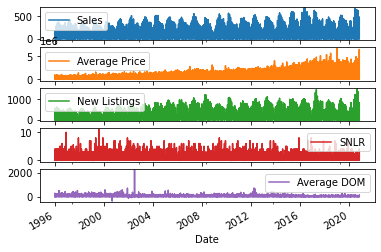

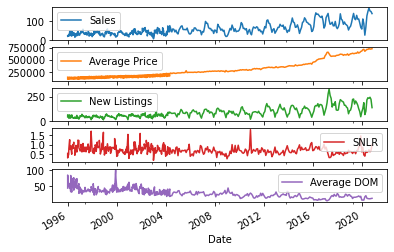

In [156]:
plot_cols = ['Sales', 'Average Price', 'New Listings', 'SNLR', 'Average DOM']
plot_features = df[plot_cols]
plot_features.index = df['Date']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:400]
plot_features.index = df['Date'][:400]
_ = plot_features.plot(subplots=True)

In [157]:
def plot_series(time, series, format="-", start=0, end=None):
    ''' 
    this function is used to plot the time series
    INPUT:
    time - the number of weeks in an array
    series - the values being plot
    format - default line plot
    OUTPUT: a plot of the time series
    '''
    plt.plot(time[start:end], series[start:end], format, label='Predicted')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
def moving_average_predict(series, window_size):
    '''
    this function gets our predictions using a moving average approach
    INPUTS:
    series - the predictions in an array
    window_size - the number of weeks in the window frame being used to calculate the moving average
    OUTPUT: an array of the predicted values
    '''
    predictions = []
    for time in range(len(series) - window_size):
        predictions.append(series[time:time + window_size].mean())
    return np.array(predictions)

In [161]:
# test moving average with subset of data
vaughan_detached = df[(df['Geography'] == 'Vaughan') & (df['HomeType'] == 'Detached')].reset_index(drop=True)

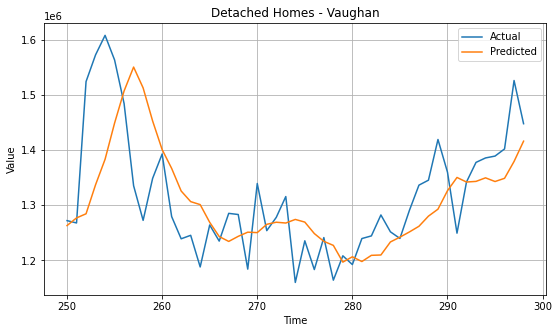

In [165]:
split_time = 250
moving_avg = moving_average_predict(vaughan_detached['Average Price'], 5)[split_time - 5:]
plt.figure(figsize=(9, 5))
plt.title('Detached Homes - Vaughan')
vaughan_detached['Average Price'][split_time:].plot(label='Actual')
plot_series(vaughan_detached['Average Price'][split_time:].index, moving_avg)
plt.legend()

In [162]:
vaughan_detached

,Date,Sales,Dollar Volume,Average Price,New Listings,SNLR,Active Listings,MOI,Average DOM,Average SP/LP,Municipality,Geography,HomeType,Month,Year,Average Price YoY,Average Price of Year,Median Price of Year
0,1996-01-01,52.0,15264890.0,2.935556e+05,195.0,0.266667,342.0,6.576923,67.384613,0.940727,York,Vaughan,Detached,1,1996,NaN,2.988742e+05,2.994222e+05
1,1996-02-01,70.0,21329250.0,3.047036e+05,209.0,0.334928,396.0,5.657143,61.671429,0.928874,York,Vaughan,Detached,2,1996,NaN,2.988742e+05,2.994222e+05
2,1996-03-01,106.0,32092738.0,3.027617e+05,206.0,0.514563,400.0,3.773585,60.216980,0.948424,York,Vaughan,Detached,3,1996,NaN,2.988742e+05,2.994222e+05
3,1996-04-01,108.0,31392800.0,2.906741e+05,184.0,0.586956,375.0,3.472222,68.361114,0.949103,York,Vaughan,Detached,4,1996,NaN,2.988742e+05,2.994222e+05
4,1996-05-01,106.0,32324450.0,3.049477e+05,213.0,0.497653,388.0,3.660377,58.075470,0.951100,York,Vaughan,Detached,5,1996,NaN,2.988742e+05,2.994222e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2020-07-01,257.0,356116599.0,1.385668e+06,451.0,0.569845,467.0,1.817121,21.085604,0.991286,York,Vaughan,Detached,7,2020,NaN,1.385803e+06,1.385668e+06
295,2020-08-01,229.0,318090118.0,1.389040e+06,467.0,0.490364,504.0,2.200873,19.812227,0.995983,York,Vaughan,Detached,8,2020,NaN,1.385803e+06,1.385668e+06
296,2020-09-01,253.0,354699341.0,1.401974e+06,499.0,0.507014,549.0,2.169961,17.893280,0.989035,York,Vaughan,Detached,9,2020,NaN,1.385803e+06,1.385668e+06
297,2020-10-01,263.0,401325494.0,1.525952e+06,402.0,0.654229,481.0,1.828897,19.528517,0.983118,York,Vaughan,Detached,10,2020,NaN,1.385803e+06,1.385668e+06


## Pytorch Forecasting

In [4]:
# add time index
df['time_idx'] = df['Date'].dt.year *12 + df['Date'].dt.month
df['time_idx'] -= df['time_idx'].min()
# create feature to get count of time_idx in case of missing time sequences
df['count_idx'] = df.groupby(['Geography','HomeType'])['time_idx'].transform('count')
# filter out time series with missing sequences
df = df[df['count_idx'] >= 200] # set a threshold of missing sequences

df['Month'] = df['Month'].astype(str).astype('category')
df['Year'] = df['Year'].astype(str).astype('category')

In [5]:
df.sample(10)

,Date,Sales,Dollar Volume,Average Price,New Listings,SNLR,Active Listings,MOI,Average DOM,Average SP/LP,...,Median Active Listings of Year,Active Listings YoY,Median MOI of Year,MOI YoY,Median DOM of Year,DOM YoY,Median SP/LP of Year,SP/LP YoY,time_idx,count_idx
124271,2002-12-01,0.0,0.0,0.00000,1.0,0.000000,1.0,0.000000,0.000000,0.000000,...,1.5,-0.769231,0.000000,-1.000000,11.833333,-0.960357,0.483739,-0.509691,83,256
117020,2014-07-01,1.0,470000.0,470000.00000,0.0,0.000000,0.0,0.000000,22.000000,0.969072,...,2.0,1.000000,0.500000,-0.333333,10.333333,0.097345,0.987676,-0.003615,222,294
36192,2013-06-01,19.0,8692900.0,457521.06250,38.0,0.500000,45.0,2.368421,19.789475,0.987293,...,31.0,0.878788,2.587500,0.116906,24.278572,-0.006786,0.979937,-0.005796,209,299
127482,1999-02-01,0.0,0.0,0.00000,3.0,0.000000,7.0,0.000000,0.000000,0.000000,...,3.5,0.000000,1.125000,-0.517857,39.600000,-0.301176,0.969226,-0.002666,37,295
103922,1997-07-01,0.0,0.0,0.00000,2.0,0.000000,2.0,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18,261
127920,2010-02-01,4.0,1362573.0,340643.25000,11.0,0.363636,28.0,7.000000,83.750000,1.002777,...,24.0,0.066667,7.166667,-0.188679,77.333332,0.050249,0.976198,0.021023,169,296
50291,2012-08-01,244.0,94699443.0,388112.46875,566.0,0.431095,1168.0,4.786885,31.344263,0.976631,...,1136.0,0.187043,4.683821,0.676699,31.843953,0.084506,0.980772,-0.004650,199,299
73941,2016-11-01,1.0,233500.0,233500.00000,2.0,0.500000,3.0,3.000000,21.000000,0.993617,...,3.0,0.500000,1.500000,0.000000,13.500000,0.000000,0.980591,0.000000,250,229
78150,2010-10-01,25.0,20580105.0,823204.18750,39.0,0.641026,50.0,2.000000,29.120001,0.956014,...,51.0,-0.128205,2.000000,0.012048,22.032693,-0.153372,0.999332,0.023409,177,299
89857,2003-08-01,29.0,8021400.0,276600.00000,52.0,0.557692,70.0,2.413793,20.034483,0.981667,...,71.0,0.267857,2.185504,0.071737,23.058093,-0.171058,0.979077,0.005223,91,299


In [6]:
df.describe()

,Sales,Dollar Volume,Average Price,New Listings,SNLR,Active Listings,MOI,Average DOM,Average SP/LP,Median Sales of Year,...,Median Active Listings of Year,Active Listings YoY,Median MOI of Year,MOI YoY,Median DOM of Year,DOM YoY,Median SP/LP of Year,SP/LP YoY,time_idx,count_idx
count,98715.000000,9.871500e+04,9.871500e+04,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,...,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000,98715.000000
mean,20.329372,9.708509e+06,3.806707e+05,34.232751,0.655538,49.164078,2.332898,29.351209,0.877803,20.242901,...,50.326050,0.086085,1.937656,0.078894,25.654175,0.028957,0.907519,-0.019064,150.211559,289.500775
std,41.626701,2.602634e+07,3.553280e+05,74.715276,0.556755,107.327173,2.461810,26.542946,0.310590,40.020906,...,108.530687,0.685097,1.480931,0.891912,16.091699,1.150297,0.250501,0.214862,85.724047,20.225880
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-349.000000,0.000000,0.000000,...,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,203.000000
25%,2.000000,5.350000e+05,1.787631e+05,3.000000,0.361772,4.000000,0.888889,13.144156,0.962943,2.000000,...,4.000000,-0.222222,1.000000,-0.254386,14.500000,-0.201744,0.966424,-0.003050,77.000000,294.000000
50%,7.000000,2.233400e+06,2.894500e+05,10.000000,0.590909,13.000000,1.824561,25.333334,0.977099,7.000000,...,13.000000,0.000000,1.750000,0.000000,23.913462,-0.029330,0.976944,0.000694,151.000000,299.000000
75%,22.000000,8.181350e+06,4.916722e+05,36.000000,0.846154,49.000000,3.000000,40.000000,0.991143,22.500000,...,51.000000,0.221014,2.625000,0.169399,35.333332,0.081695,0.988093,0.007628,224.000000,299.000000
max,679.000000,6.579971e+08,6.724000e+06,1478.000000,11.000000,1877.000000,48.500000,2218.333252,2.143134,502.000000,...,1656.000000,35.000000,13.000000,31.500000,298.500000,57.000000,1.182183,1.489072,298.000000,299.000000


In [192]:
df.columns

Index(['Date', 'Sales', 'Dollar Volume', 'Average Price', 'New Listings',
       'SNLR', 'Active Listings', 'MOI', 'Average DOM', 'Average SP/LP',
       'Municipality', 'Geography', 'HomeType', 'Month', 'Year',
       'Median Sales of Year', 'Sales YoY', 'Median Price of Year',
       'Price YoY', 'Median New Listings of Year', 'New Listings YoY',
       'Median SNLR of Year', 'SNLR YoY', 'Median Active Listings of Year',
       'Active Listings YoY', 'Median MOI of Year', 'MOI YoY',
       'Median DOM of Year', 'DOM YoY', 'Median SP/LP of Year', 'SP/LP YoY',
       'time_idx'],
      dtype='object')

In [7]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Average Price",
    group_ids=["Geography", "HomeType"],
    min_encoder_length=max_encoder_length // 3,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Geography", "HomeType"],
    static_reals=[],
    time_varying_known_categoricals=["Year", "Month"],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Sales",
        "Average Price",
        "Dollar Volume",
        "New Listings",
        "SNLR",
        "Active Listings",
        "MOI",
        "Average DOM",
        "Average SP/LP",
        "Median Price of Year"
    ],
    target_normalizer=GroupNormalizer(
        groups=["Geography", "HomeType"]
    ),  # use softplus and normalize by group
    allow_missings = True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(dataset=training, data=df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Create a Baseline model

Evaluating a Baseline model that predicts the next 6 months by simply repeating the last observed Average Price gives us a simple benchmark that we want to outperform.



In [8]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

198766.515625

In [9]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Number of parameters in network: 28.0k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.4 K 
3  | prescalers                         | ModuleDict                      | 240   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\Michael\MLS\lr_find_temp_model.ckpt


suggested learning rate: 0.20892961308540398


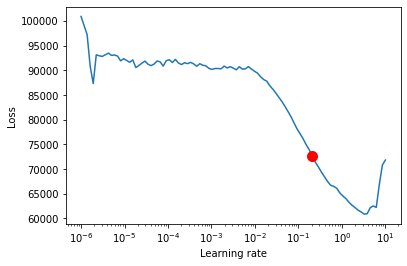

<ipython-input-10-a92b5627800b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [10]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [11]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Number of parameters in network: 28.0k


In [12]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.4 K 
3  | prescalers                         | ModuleDict                      | 240   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [13]:

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)


[I 2021-02-07 13:20:43,258] A new study created in memory with name: no-name-94148e6c-916a-4da8-af5b-f72c555805bb
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 13:29:07,456] Trial 0 finished with value: 45373.63671875 and parameters: {'gradient_clip_val': 0.012585941737503006, 'hidden_size': 13, 'dropout': 0.2156501066202483, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.005536742208102478}. Best is trial 0 with value: 45373.63671875.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 13:39:18,949] Trial 1 finished with value: 41319.046875 and parameters: {'gradient_clip_val': 0.4801201242000309, 'hidden_size': 31, 'dropout': 0.24109510579873988, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.009351279414079582}. Best is trial 1 with value: 41319.046875.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 13:39:42,610

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 14:54:00,714] Trial 46 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 14:54:46,944] Trial 47 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 14:55:42,312] Trial 48 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 14:56:47,134] Trial 49 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 14:57:32,346] Trial 50 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 14:58:21,711] Trial 51 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 15:00:49,737] Trial 52 p

[I 2021-02-07 17:17:03,079] Trial 95 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 17:25:04,533] Trial 96 pruned. Trial was pruned at epoch 16.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 17:25:38,589] Trial 97 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 17:27:45,391] Trial 98 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 17:44:45,196] Trial 99 finished with value: 38779.4921875 and parameters: {'gradient_clip_val': 0.019219244560754977, 'hidden_size': 107, 'dropout': 0.21110861579070483, 'hidden_continuous_size': 26, 'attention_head_size': 2, 'learning_rate': 0.021113812546738463}. Best is trial 99 with value: 38779.4921875.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-0

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 18:48:10,668] Trial 143 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 18:48:47,722] Trial 144 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 18:49:10,932] Trial 145 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 18:50:36,130] Trial 146 pruned. Trial was pruned at epoch 4.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 18:51:05,404] Trial 147 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 18:51:49,901] Trial 148 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 18:52:10,557] Tria

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 20:09:07,483] Trial 191 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 20:09:44,811] Trial 192 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 20:10:17,038] Trial 193 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 20:11:00,894] Trial 194 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 20:11:52,057] Trial 195 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 20:12:58,262] Trial 196 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
[I 2021-02-07 20:13:38,034] Tria

NameError: name 'pickle' is not defined

In [15]:
# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

{'gradient_clip_val': 0.019219244560754977, 'hidden_size': 107, 'dropout': 0.21110861579070483, 'hidden_continuous_size': 26, 'attention_head_size': 2, 'learning_rate': 0.021113812546738463}


In [16]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [17]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(154726.)

In [18]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

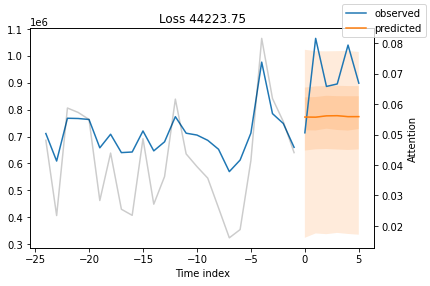

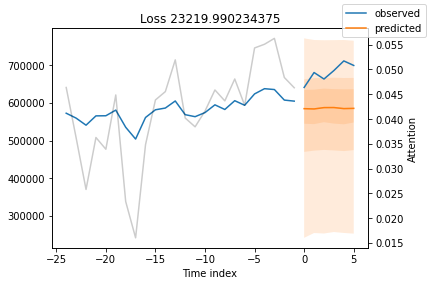

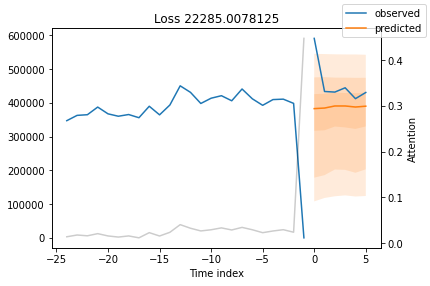

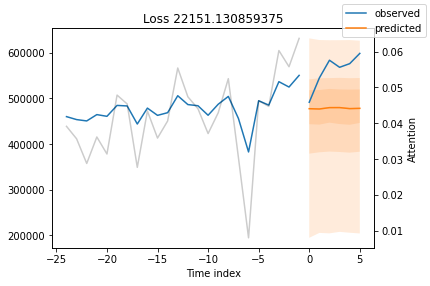

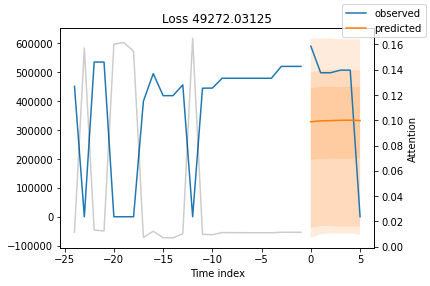

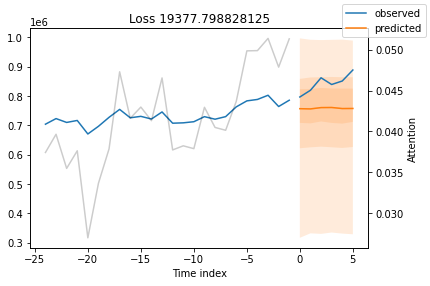

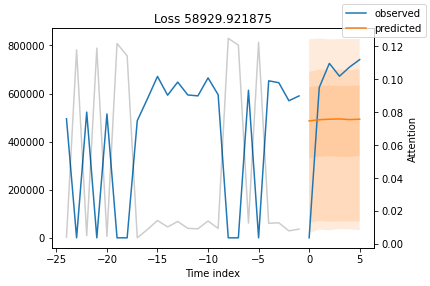

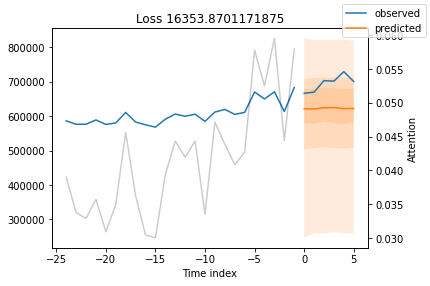

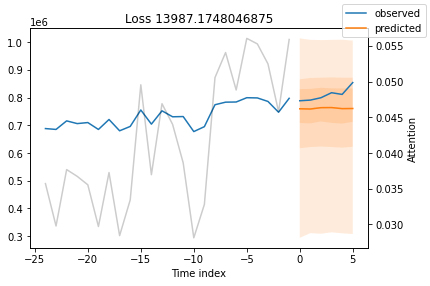

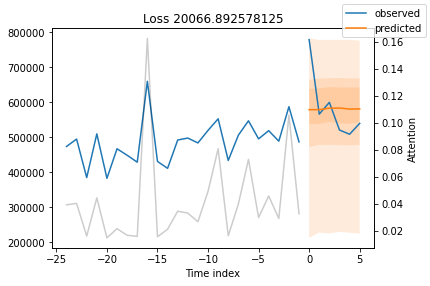

In [19]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

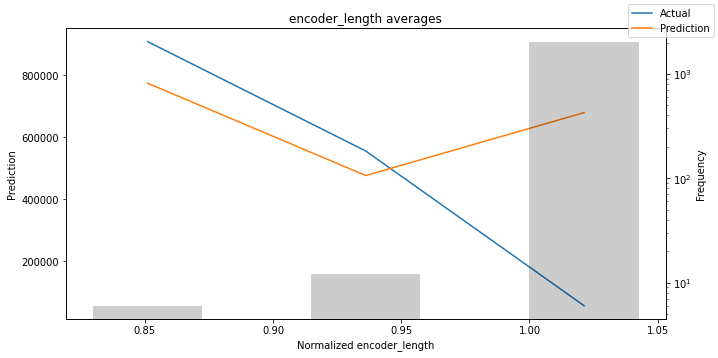

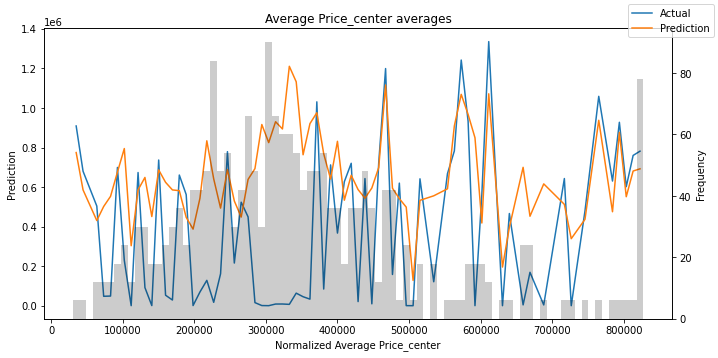

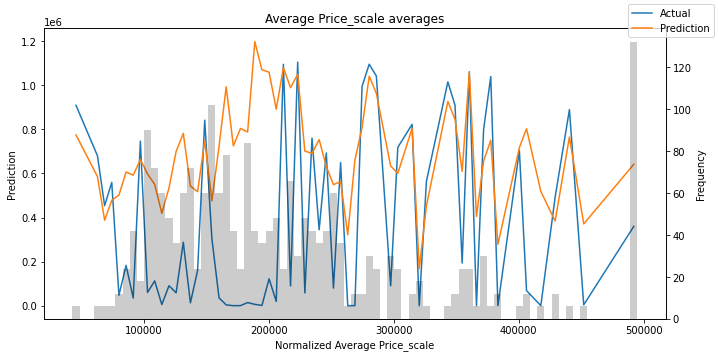

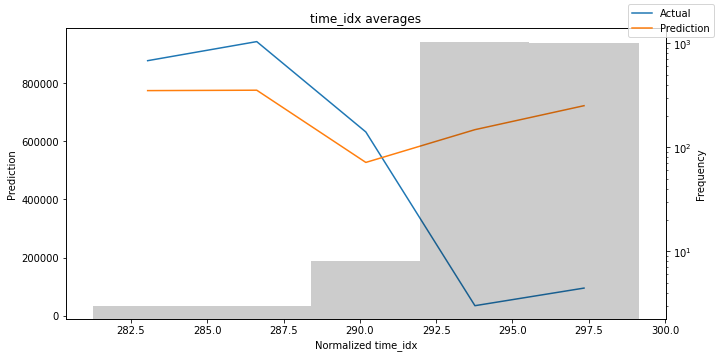

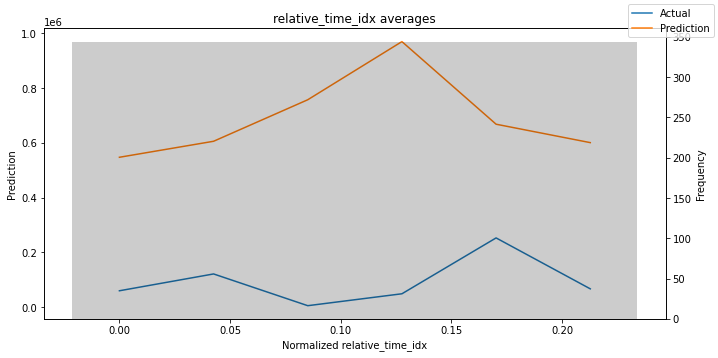

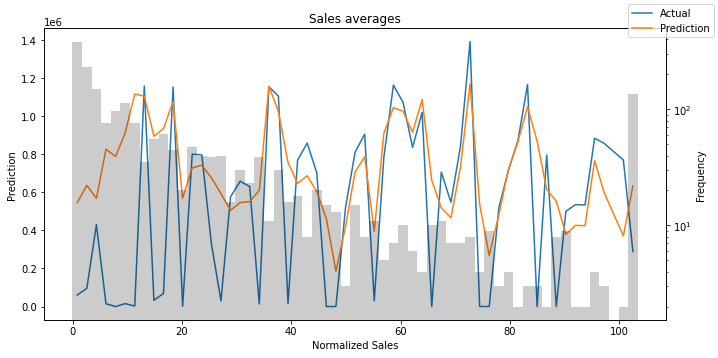

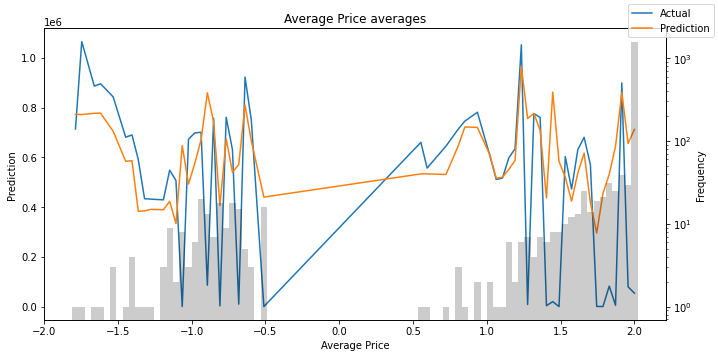

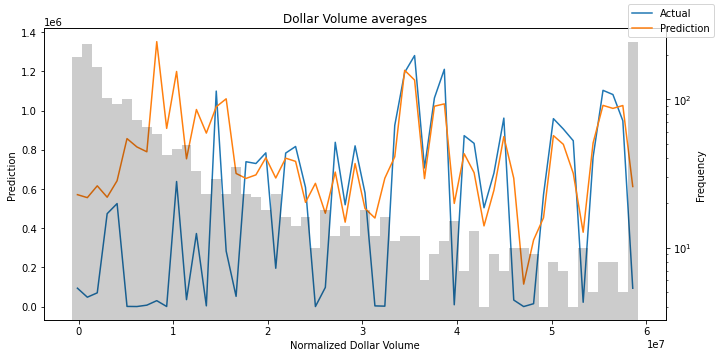

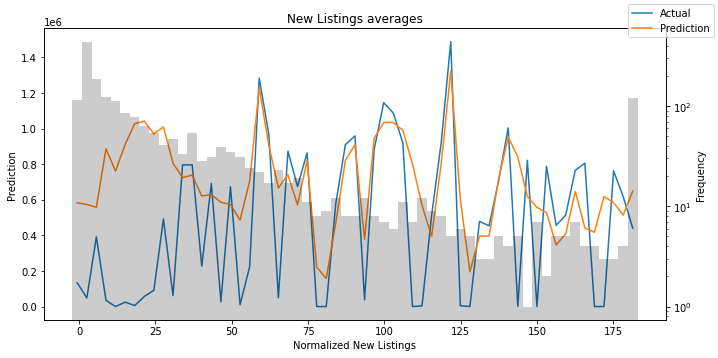

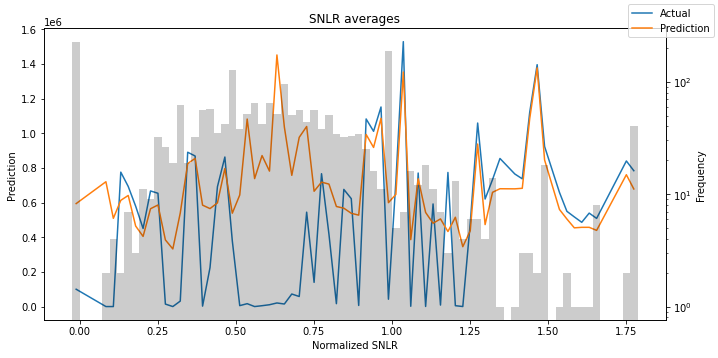

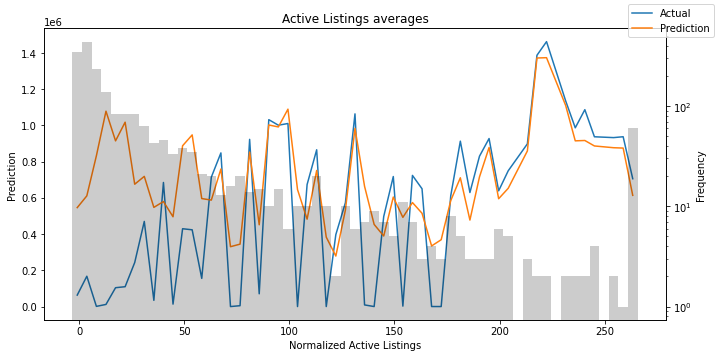

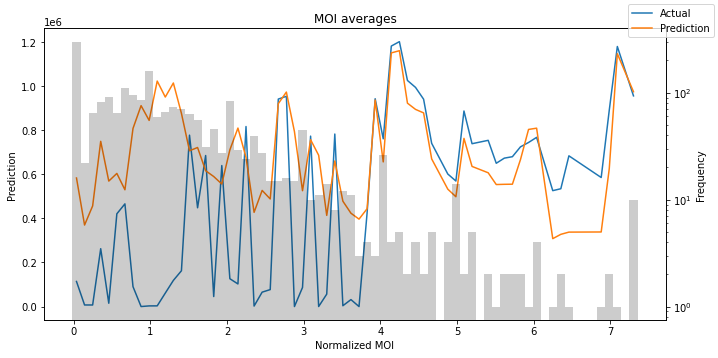

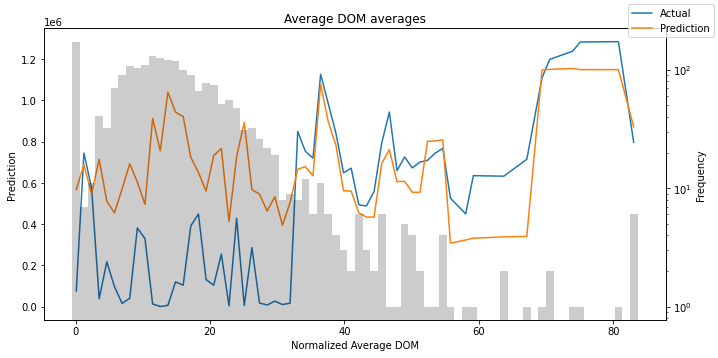

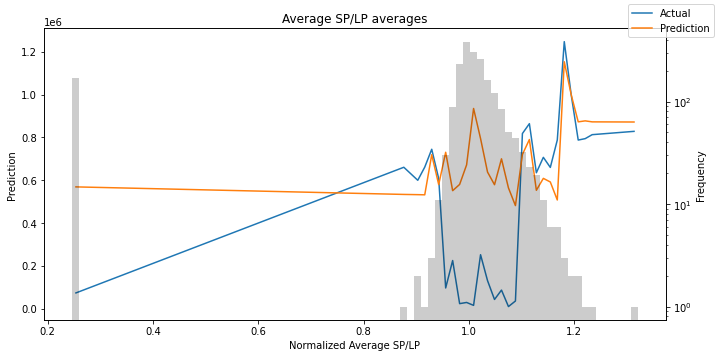

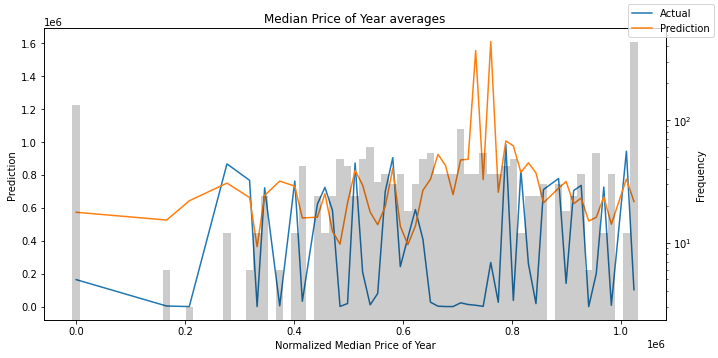

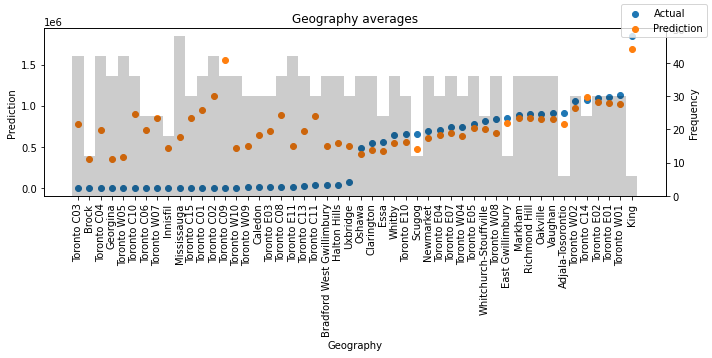

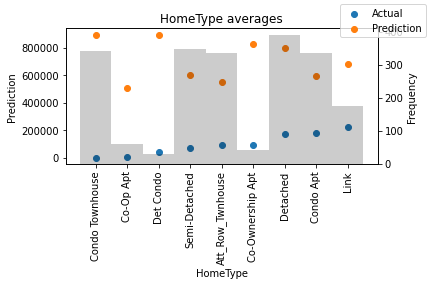

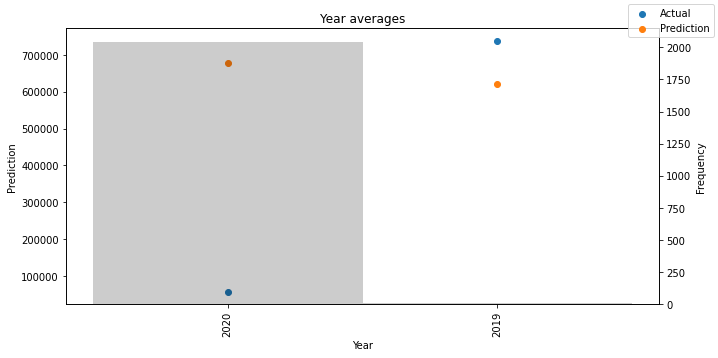

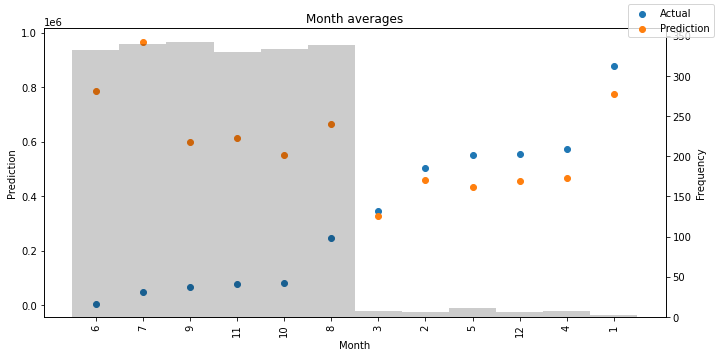

In [20]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [23]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices
last_data = df[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.Date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

C:\Users\Michael\AppData\Roaming\Python\Python38\site-packages\pytorch_forecasting\data\timeseries.py:1227: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Geography': 'Toronto E11', '__group_id__HomeType': 'Det Condo'}]
  warnings.warn(


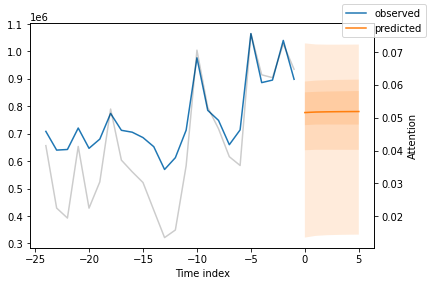

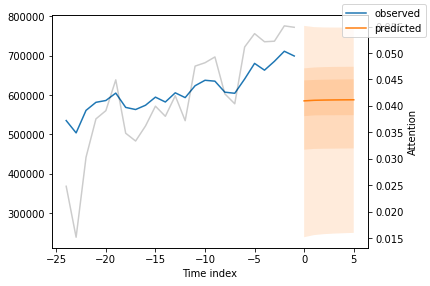

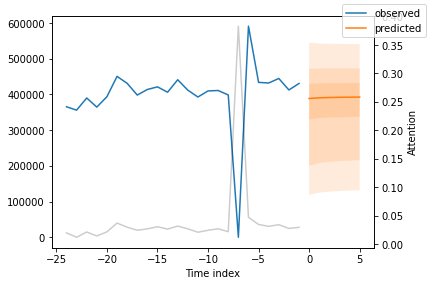

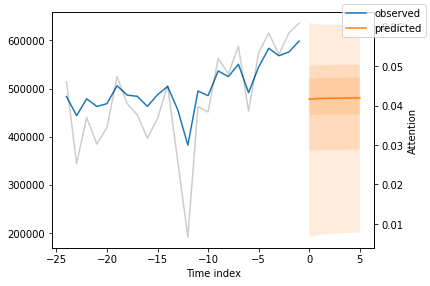

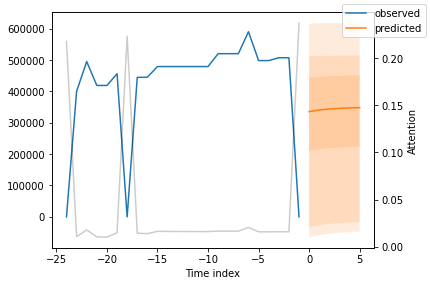

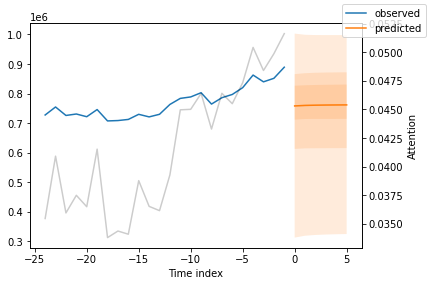

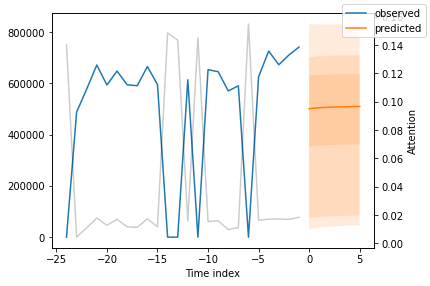

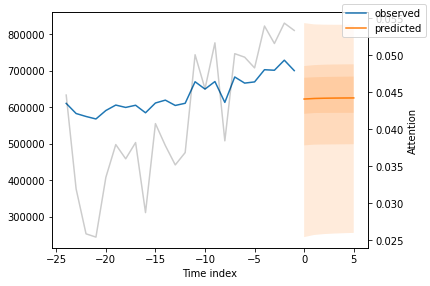

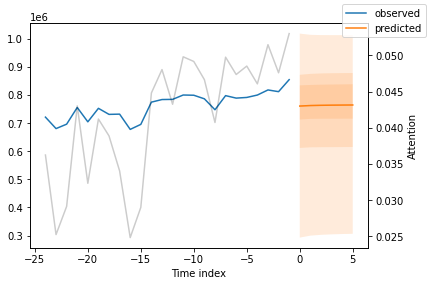

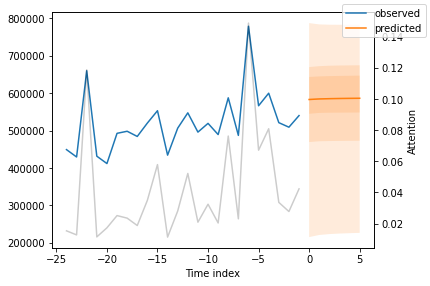

In [24]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x396 with 1 Axes>,
 'decoder_variables': <Figure size 504x216 with 1 Axes>}

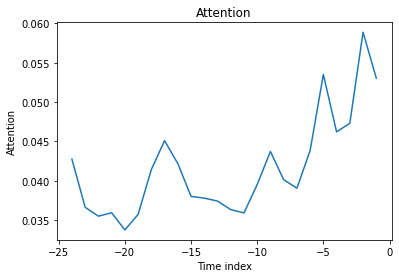

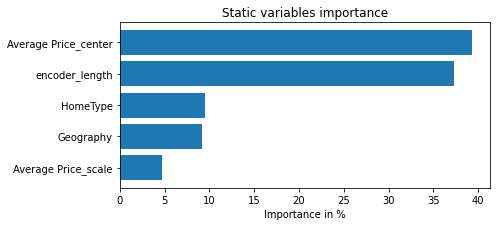

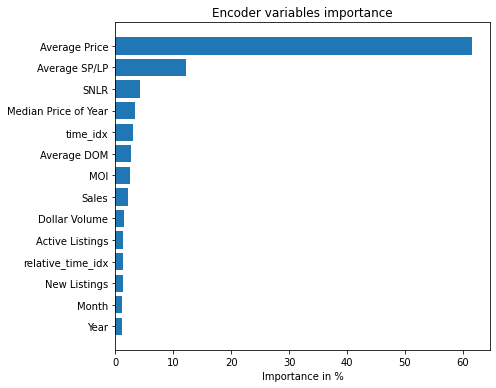

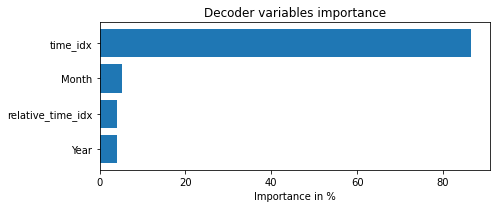

In [25]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)